### Overview

Corn is susceptible to many diseases throughout the season; Gray Leaf Spot, Northern Corn Leaf Blight, and Common Rust are three of the most common. As explained by Bayer Crop Science, "Managing these diseases early is essential to keeping your corn crop healthy and protecting your yields."

Corn is an integral part of the agricultural ecosystem and both the American and global economy. According to the United States Grain Council, the US is the largest corn producer in the world, with 96,000,000 acres of land reserved for corn production.
Considering how much of an impact corn has on agriculture and economy, it is imperative that farmers be able to avoid the occurrence of leaf diseases affecting their crops. With acres of corn to care for, it can be difficult and time-consuming to identify diseased plants. Since diseased corn plants are not able to be harvested, continuing to water them and care for them is a waste of resources and time

The following project uses deep learning to classify images of healthy and diseased corn leaves in the hopes of helping stakeholders to catch disease early. After identifying a disease, stakeholders can make intelligent decisions to ensure healthy crop in future seasons. 

### Data Understanding

Our data was sourced from https://www.kaggle.com/smaranjitghose/corn-or-maize-leaf-disease-dataset .
This is a dataset for classification of corn/maize plant leaf diseases.
The images are in 4 folders, classified as follows: 
0. Common Rust - 1306 images
1. Gray Leaf Spot - 574 images
2. Blight - 1146 images
3. Healthy - 1162 images

(The following disease explanations are from the Crop Protection Network, and more information can be found at https://cropprotectionnetwork.org/.)



In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import Dense
from keras import models, layers
from keras.utils import plot_model
import numpy as np 
import pandas as pd
from PIL import Image
import glob
import os, os.path, shutil
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import pydot
import random
from dask import bag,  diagnostics 

### Basic EDA

In [3]:
#open first image and check size
im = Image.open('data/Blight/Corn_Blight (1).jpg')
arr = np.array(im)
arr.shape

(371, 788, 3)

In [4]:
# Directory with Blight pictures
blight_dir = os.path.join('./data/Blight')

# Directory with Common Rust pictures
rust_dir = os.path.join('./data/Common_Rust')

# Directory with Gray Leaf Spot pictures
gray_dir = os.path.join('./data/Gray_Leaf_Spot')

# Directory with Healthy pictures
healthy_dir = os.path.join('./data/Healthy')

In [5]:
train_blight_names = os.listdir(blight_dir)
no_blight = len(os.listdir(blight_dir))
print('Total Blight Images:', len(os.listdir(blight_dir)))
print(train_blight_names[:5])
print('')

train_rust_names = os.listdir(rust_dir)
no_rust = len(os.listdir(rust_dir))
print('Total Common Rust Images:', len(os.listdir(rust_dir)))
print(train_rust_names[:5])
print('')

train_gray_names = os.listdir(gray_dir)
no_gray = len(os.listdir(gray_dir))
print('Total Gray Leaf Spot Images:', len(os.listdir(gray_dir)))
print(train_gray_names[:5])
print('')

train_healthy_names = os.listdir(healthy_dir)
no_healthy = len(os.listdir(healthy_dir))
print('Total Healthy Images:', len(os.listdir(healthy_dir)))
print(train_healthy_names[:5])

Total Blight Images: 1146
['Corn_Blight (1).jpg', 'Corn_Blight (1146).jpg', 'Corn_Blight (1147).jpg', 'Corn_Blight (1148).jpg', 'Corn_Blight (1149).jpg']

Total Common Rust Images: 1306
['Corn_Common_Rust (1).jpg', 'Corn_Common_Rust (10).jpg', 'Corn_Common_Rust (100).JPG', 'Corn_Common_Rust (1000).JPG', 'Corn_Common_Rust (1001).JPG']

Total Gray Leaf Spot Images: 574
['Corn_Gray_Spot (1).jpg', 'Corn_Gray_Spot (10).jpg', 'Corn_Gray_Spot (100).JPG', 'Corn_Gray_Spot (101).JPG', 'Corn_Gray_Spot (102).JPG']

Total Healthy Images: 1162
['Corn_Health (1).jpg', 'Corn_Health (10).jpg', 'Corn_Health (100).jpg', 'Corn_Health (1000).jpg', 'Corn_Health (1001).jpg']


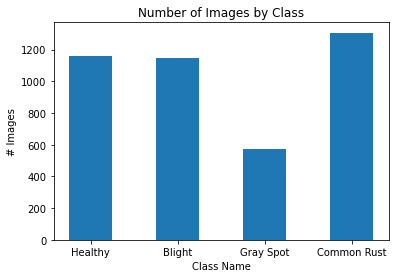

In [6]:
#plot number of classes to identify possible imbalances
number_classes = {'Healthy': 1162,
                 'Blight': 1146,
                 'Gray Spot': 574,
                 'Common Rust': 1306}

plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

#### View sample images of each class

In [7]:
# Show images displayed 4x4
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

pic_index += 8
next_blight_pix = [os.path.join(blight_dir, fname) 
                for fname in train_blight_names[pic_index-8:pic_index]]
next_rust_pix = [os.path.join(rust_dir, fname) 
                for fname in train_rust_names[pic_index-8:pic_index]]
next_gray_pix = [os.path.join(gray_dir, fname) 
                for fname in train_gray_names[pic_index-8:pic_index]]
next_healthy_pix = [os.path.join(healthy_dir, fname) 
                for fname in train_healthy_names[pic_index-8:pic_index]]

def show_image_sample(pic_directory):
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    for i, img_path in enumerate(pic_directory):
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        img = mpimg.imread(img_path)
        plt.imshow(img)
    plt.show()

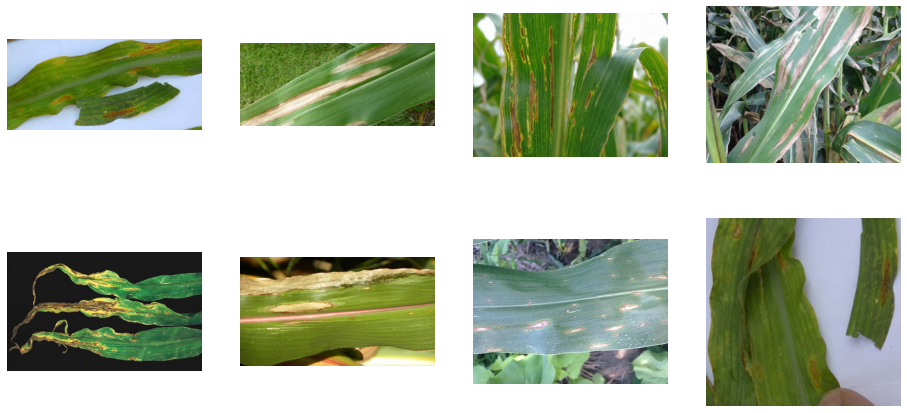

In [8]:
# Showing sample of Blight images
show_image_sample(next_blight_pix)

"Northern corn leaf blight (NCLB) is caused by the fungus Setosphaeria turcica. Symptoms usually appear first on the lower leaves. Leaf lesions are long (1 to 6 inches) and elliptical, gray-green at first but then turn pale gray or tan. Under moist conditions, dark gray spores are produced, usually on the lower leaf surface, which give lesions a "dirty" gray appearance. Entire leaves on severely blighted plants can die, so individual lesions are not visible. Lesions may occur on the outer husk of ears, but the kernels are not infected. On hybrids that contain an Ht gene for resistance to the fungus, lesions are smaller, chlorotic, and may develop into linear streaks. These lesions rarely produce spores." 
https://cropprotectionnetwork.org/

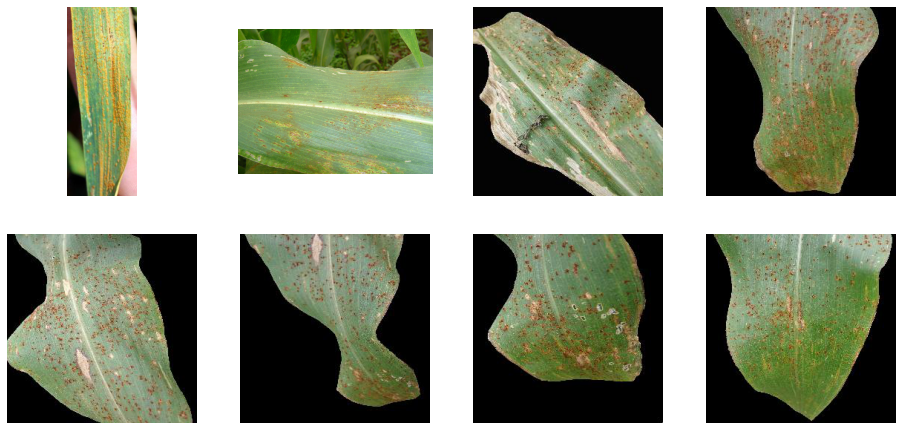

In [9]:
# Showing sample of Common Rust images
show_image_sample(next_rust_pix)

"Common rust is caused by the fungus Puccinia sorghi and occurs every growing season. It is seldom a concern in hybrid corn. Rust pustules usually first appear in late June. Early symptoms of common rust are chlorotic flecks on the leaf surface. These soon develop into powdery, brick-red pustules as the spores break through the leaf surface. Pustules are oval or elongated, about 1/8 inch long, and scattered sparsely or clustered together. The leaf tissue around the pustules may become yellow or die, leaving lesions of dead tissue. The lesions sometimes form a band across the leaf and entire leaves will die if severely infected. As the pustules age, the red spores turn black, so the pustules appear black, and continue to erupt through the leaf surface. Husks, leaf sheaths, and stalks also may be infected." https://cropprotectionnetwork.org/

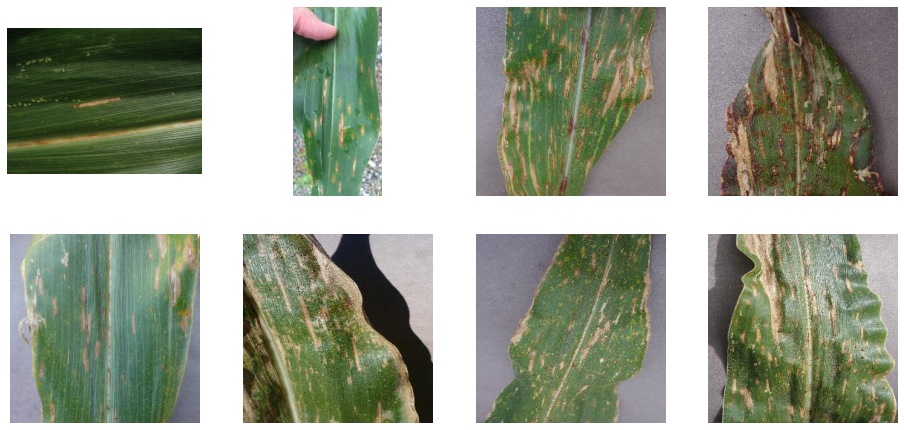

In [10]:
# Showing sample of Gray Leaf Spot images
show_image_sample(next_gray_pix)

"Gray leaf spot, caused by the fungus Cercospora zeae-maydis, occurs virtually every growing season. If conditions favor disease development, economic losses can occur. Symptoms first appear on lower leaves about two to three weeks before tasseling. The leaf lesions are long (up to 2 inches), narrow, rectangular, and light tan colored. Later, the lesions can turn gray. They are usually delimited by leaf veins but can join together and kill entire leaves." https://cropprotectionnetwork.org/

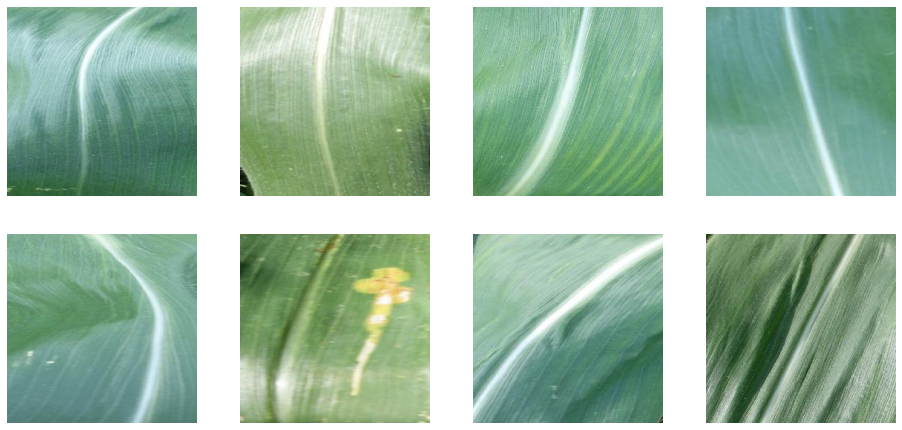

In [11]:
# Showing sample of Healthy images
show_image_sample(next_healthy_pix)

#### Visualize Image Size before Preprocessing/ Resizing

[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  1.9s


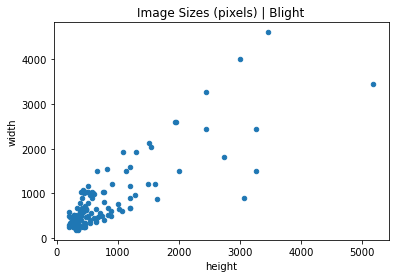

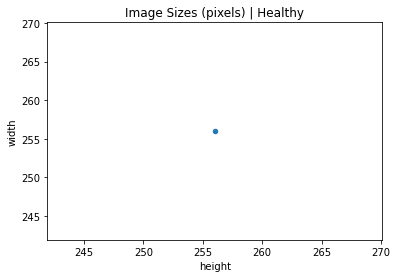

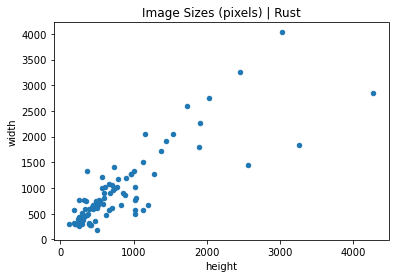

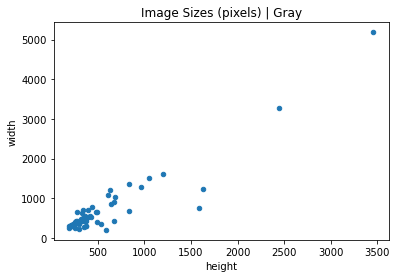

In [14]:
directories = {'Blight': 'data/Blight/',
               'Healthy': 'data/Healthy/', 
               'Rust': 'data/Common_Rust/', 
               'Gray': 'data/Gray_Leaf_Spot/'}

def get_dims(file):
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w

for n,d in directories.items(): 
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dimsbag = bag.from_sequence(filelist).map(get_dims)
    with diagnostics.ProgressBar():
        dims = dimsbag.compute()
        
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='height', y='width');
    plt.title('Image Sizes (pixels) | {}'.format(n))

These images are many different sizes, resizing will need to be applied to all images before modeling.

### Splitting Images to Train/ Test Directories

In [11]:
#grab image names for each type
imgs_blight = [file for file in os.listdir(blight_dir)]
imgs_gray = [file for file in os.listdir(gray_dir)]
imgs_rust = [file for file in os.listdir(rust_dir)]
imgs_healthy = [file for file in os.listdir(healthy_dir)]

In [12]:
new_dir = 'split/'

In [13]:
#Check to ensure all images are included
print('# Blight: ', len(imgs_blight))
print('# Gray: ', len(imgs_gray))
print('# Rust: ', len(imgs_rust))
print('# Healthy: ', len(imgs_healthy))

# Blight:  1146
# Gray:  574
# Rust:  1306
# Healthy:  1162


In [14]:
#os.mkdir(new_dir)

#create variables for new split directories for train/ test
train_folder = os.path.join(new_dir, 'train')
train_blight = os.path.join(train_folder, 'blight')
train_gray = os.path.join(train_folder, 'gray')
train_rust = os.path.join(train_folder, 'rust')
train_healthy = os.path.join(train_folder, 'healthy')

test_folder = os.path.join(new_dir, 'test')
test_blight = os.path.join(test_folder, 'blight')
test_gray = os.path.join(test_folder, 'gray')
test_rust = os.path.join(test_folder, 'rust')
test_healthy = os.path.join(test_folder, 'healthy')

In [15]:
# #create directories for splits
# os.mkdir(train_folder)
# os.mkdir(train_blight)
# os.mkdir(train_gray)
# os.mkdir(train_rust)
# os.mkdir(train_healthy)

# os.mkdir(test_folder)
# os.mkdir(test_blight)
# os.mkdir(test_gray)
# os.mkdir(test_rust)
# os.mkdir(test_healthy)

In [16]:
#use a 74/13/13 split for train/ test 
print('Number of images to test:')
print('# Blight: ', round(len(imgs_blight)*.13))
print('# Gray: ', round(len(imgs_gray)*.13))
print('# Rust: ', round(len(imgs_rust)*.13))
print('# Healthy: ', round(len(imgs_healthy)*.13))

Number of images to test:
# Blight:  149
# Gray:  75
# Rust:  170
# Healthy:  151


In [17]:
# #train blight
# imgs = imgs_blight[149:]
# for img in imgs:
#     origin = os.path.join(blight_dir, img)
#     destination = os.path.join(train_blight, img)
#     shutil.copyfile(origin, destination)
    
# #train grey
# imgs = imgs_gray[75:]
# for img in imgs:
#     origin = os.path.join(gray_dir, img)
#     destination = os.path.join(train_gray, img)
#     shutil.copyfile(origin, destination)
    
# #train rust
# imgs = imgs_rust[170:]
# for img in imgs:
#     origin = os.path.join(rust_dir, img)
#     destination = os.path.join(train_rust, img)
#     shutil.copyfile(origin, destination)
    
# #train healthy
# imgs = imgs_healthy[151:]
# for img in imgs:
#     origin = os.path.join(healthy_dir, img)
#     destination = os.path.join(train_healthy, img)
#     shutil.copyfile(origin, destination)

In [18]:
# # test blight
# imgs = imgs_blight[:149]
# for img in imgs:
#     origin = os.path.join(blight_dir, img)
#     destination = os.path.join(test_blight, img)
#     shutil.copyfile(origin, destination)
    
# # test grey
# imgs = imgs_gray[:75]
# for img in imgs:
#     origin = os.path.join(gray_dir, img)
#     destination = os.path.join(test_gray, img)
#     shutil.copyfile(origin, destination)
    
# # test rust
# imgs = imgs_rust[:170]
# for img in imgs:
#     origin = os.path.join(rust_dir, img)
#     destination = os.path.join(test_rust, img)
#     shutil.copyfile(origin, destination)
    
# # test healthy
# imgs = imgs_healthy[:151]
# for img in imgs:
#     origin = os.path.join(healthy_dir, img)
#     destination = os.path.join(test_healthy, img)
#     shutil.copyfile(origin, destination)

In [19]:
classes = ['blight','rust','gray','healthy']
num_epochs = 30
batch_size = 32

In [20]:
# Rescaling images by 1./255
# Splitting data into training and test sets
train_datagen = ImageDataGenerator(rescale = 1/255,
                                  validation_split = 0.2)

# Flow training images in batches
train_generator = train_datagen.flow_from_directory(
        './split/train',
        target_size=(200, 200),
        batch_size=batch_size,
        classes = classes,
        class_mode='categorical',
        subset='training')

# Flow validation images in batches
validation_generator = train_datagen.flow_from_directory(
        './split/train',
        target_size=(200, 200),
        batch_size=batch_size,
        classes = classes,
        class_mode='categorical',
        subset='validation')

Found 2916 images belonging to 4 classes.
Found 727 images belonging to 4 classes.


In [21]:
#create images/ labels
train_images, train_labels = next(train_generator)

In [23]:
train_images.shape[0]

32

In [24]:
# train_img = train_images.reshape(train_images.shape[0], -1)
# test_img = test_images.reshape(test_images.shape[0], -1)
# val_img = val_images.reshape(val_images.shape[0], -1)

# #double check shape to make sure all the images are included
# print(train_img.shape)
# print(test_img.shape)
# print(val_img.shape)

In [98]:
##create labels for all three splits
#train_y = np.reshape(train_labels[:,0], (3099,1))

### Modeling with CNN's

#### Baseline Model: CNN with a Single Convolutional Layer & Softmax Output

In [55]:
classes = ['blight','rust','gray','healthy']
num_epochs = 30
batch_size = 32

# Training sample count
training_sample=train_generator.n 
    
# Validation sample count
val_sample=validation_generator.n

In [26]:
training_sample

2916

In [34]:
#first CNN with 2 convolutional layers

input_shape = (64, 64, 3)
x = tf.random.normal(input_shape)
    
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (5,5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

#Compiling with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(lr=.003),
                loss="categorical_crossentropy",
                metrics='accuracy')

In [35]:
history_cnn = model.fit(train_generator,
                    epochs=30,
                    batch_size=batch_size,
                    steps_per_epoch=int((training_sample//batch_size)-1),
                    validation_data= validation_generator)

Epoch 1/30
90/90 [==============================] - 146s 2s/step - loss: 1.2952 - accuracy: 0.5435 - val_loss: 1.0233 - val_accuracy: 0.5172
Epoch 2/30
90/90 [==============================] - 147s 2s/step - loss: 0.8594 - accuracy: 0.5631 - val_loss: 1.0837 - val_accuracy: 0.5227
Epoch 3/30
90/90 [==============================] - 149s 2s/step - loss: 0.8282 - accuracy: 0.5687 - val_loss: 1.1042 - val_accuracy: 0.5227
Epoch 4/30
90/90 [==============================] - 145s 2s/step - loss: 0.8195 - accuracy: 0.5582 - val_loss: 1.0849 - val_accuracy: 0.5199
Epoch 5/30
90/90 [==============================] - 147s 2s/step - loss: 1.0256 - accuracy: 0.5533 - val_loss: 1.0639 - val_accuracy: 0.5186
Epoch 6/30
90/90 [==============================] - 141s 2s/step - loss: 0.8780 - accuracy: 0.5614 - val_loss: 1.0444 - val_accuracy: 0.5172
Epoch 7/30
90/90 [==============================] - 145s 2s/step - loss: 0.8171 - accuracy: 0.5600 - val_loss: 1.0564 - val_accuracy: 0.5241
Epoch 8/30
90

In [ ]:
def viz_train_res(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

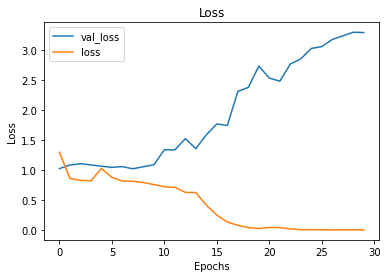

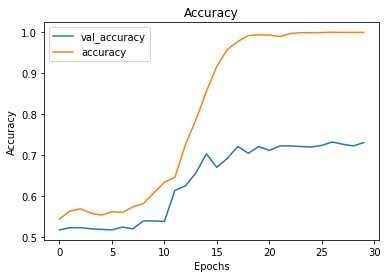

In [36]:
viz_train_res(history_cnn)

While training accuracy is very high, this model is overfitting and not performing as well on the validation set. Overfitting on training data is common in neural networks, so this issue isn't surpising. However, it poses an issue as the model won't perform as well on data it hasn't seen before - meaning this model would not perform well in the wild.
The following models will focus on improving validation performance.  

In [27]:
#CNN with a single convolutional layer to combat overfitting

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # 4 output neurons for 4 classes
    tf.keras.layers.Dense(4, activation='softmax')
])

In [28]:
# Compiling with RMSprop optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [29]:
# Training model
history_cnn2 = model.fit(train_generator,
    steps_per_epoch=int((training_sample//batch_size)-1),
    validation_data = (validation_generator),
    validation_steps = int((val_sample//batch_size)-1),
    epochs=num_epochs,
    verbose=1)

Epoch 1/30
90/90 [==============================] - 58s 649ms/step - loss: 8.2105 - accuracy: 0.6059 - val_loss: 1.4920 - val_accuracy: 0.6533
Epoch 2/30
90/90 [==============================] - 57s 633ms/step - loss: 0.4700 - accuracy: 0.8278 - val_loss: 0.5843 - val_accuracy: 0.7738
Epoch 3/30
90/90 [==============================] - 55s 613ms/step - loss: 0.3231 - accuracy: 0.8787 - val_loss: 0.5232 - val_accuracy: 0.7991
Epoch 4/30
90/90 [==============================] - 56s 620ms/step - loss: 0.2138 - accuracy: 0.9313 - val_loss: 0.6055 - val_accuracy: 0.8021
Epoch 5/30
90/90 [==============================] - 56s 618ms/step - loss: 0.1458 - accuracy: 0.9541 - val_loss: 0.6106 - val_accuracy: 0.8259
Epoch 6/30
90/90 [==============================] - 55s 614ms/step - loss: 0.1090 - accuracy: 0.9727 - val_loss: 0.5798 - val_accuracy: 0.8408
Epoch 7/30
90/90 [==============================] - 56s 625ms/step - loss: 0.0870 - accuracy: 0.9818 - val_loss: 0.5864 - val_accuracy: 0.8452

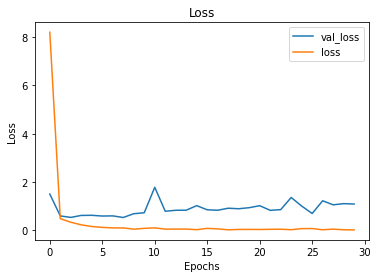

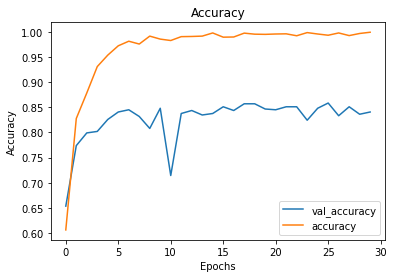

In [33]:
viz_train_res(history_cnn2)

Reducing the number of layers is often an easy way to solve for overfitting. We can see here that while it certainly helped reduce overfitting, there is still more work to be done. Overall, our validation loss isn't as high. Validation accuracy is still suffering from overfitting.

#### Reloading Images and Applying Data Augmentation

Another way to combat overfitting in image classification is with data augmentation. This process takes an image and changes it in various ways so that the model learns to differentiate to images in many different formats and appearances.

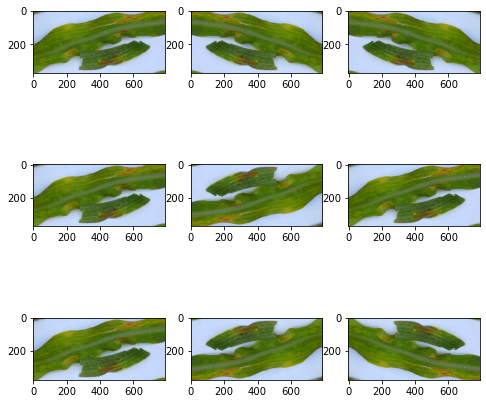

In [49]:
# Blight leaf image
img = load_img('data/Blight/Corn_Blight (1).jpg')
data = img_to_array(img)
samples = np.expand_dims(data, 0)
# Demonstrating horizontal and vertical flips
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
fig=plt.gcf()
fig.set_size_inches(ncols * 2, nrows * 2)
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

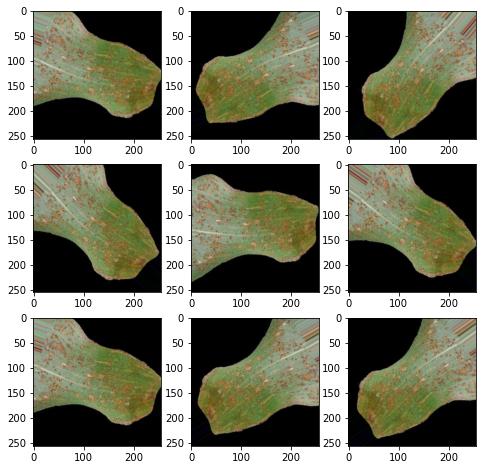

In [50]:
# Data augmentation example
# Common Rust leaf image
img = load_img('./data/Common_Rust/Corn_Common_Rust (1000).JPG')
data = img_to_array(img)
samples = np.expand_dims(data, 0)
# Demonstrating random rotation
datagen = ImageDataGenerator(rotation_range=90, fill_mode='nearest')
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
fig=plt.gcf()
fig.set_size_inches(ncols * 2, nrows * 2)
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

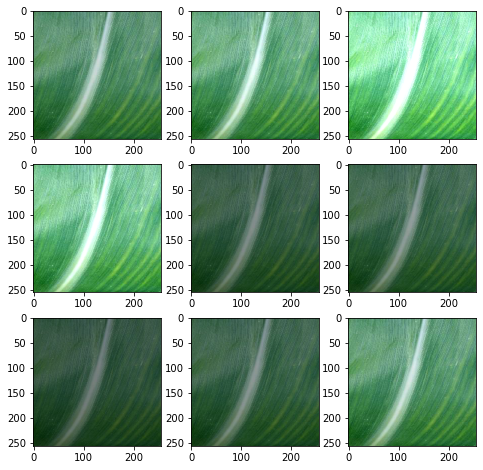

In [51]:
# Healthy leaf image
img = load_img('./data/Healthy/Corn_Health (100).jpg')
data = img_to_array(img)
samples = np.expand_dims(data, 0)
# Demonstrating brightness augmentation
datagen = ImageDataGenerator(brightness_range=[0.4,1.5])
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
fig=plt.gcf()
fig.set_size_inches(ncols * 2, nrows * 2)
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

To ensure that our model can generalize to the validation data and not overfit to the training data, we will be randomly augmenting the training images using the methods shown above.

In [52]:
# Rescaling images by 1./255
# Splitting data into training and validation sets
# Performing data augmentation on training images
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range=90, fill_mode='nearest',
                                   brightness_range=[0.4,1.5],
                                   validation_split = 0.2)

# Flow training images in batches
train_generator = train_datagen.flow_from_directory(
        './split/train',
        target_size=(200, 200),
        batch_size=batch_size,
        classes = classes,
        class_mode='categorical',
        subset='training')

# Flow validation images in batches
validation_generator = train_datagen.flow_from_directory(
        './split/train',
        target_size=(200, 200),
        batch_size=batch_size,
        classes = classes,
        class_mode='categorical',
        subset='validation')

Found 2916 images belonging to 4 classes.
Found 727 images belonging to 4 classes.


#### Next CNNs using Data Augmentation & Adam Optimizer

In [41]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # 4 output neurons for 4 classes
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compiling with adam optimizer
model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    
# Training
history_cnn3 = model_3.fit(
        train_generator, 
        steps_per_epoch=int(training_sample/batch_size),
        validation_data = validation_generator,
        validation_steps = int(val_sample/batch_size),
        epochs=num_epochs,
        verbose=1)

Epoch 1/30
91/91 [==============================] - 139s 2s/step - loss: 2.1959 - acc: 0.6886 - val_loss: 0.5028 - val_acc: 0.8196
Epoch 2/30
91/91 [==============================] - 131s 1s/step - loss: 0.4366 - acc: 0.8284 - val_loss: 0.5882 - val_acc: 0.7656
Epoch 3/30
91/91 [==============================] - 132s 1s/step - loss: 0.4441 - acc: 0.8298 - val_loss: 0.4784 - val_acc: 0.8182
Epoch 4/30
91/91 [==============================] - 127s 1s/step - loss: 0.3780 - acc: 0.8561 - val_loss: 0.5598 - val_acc: 0.8125
Epoch 5/30
91/91 [==============================] - 123s 1s/step - loss: 0.3767 - acc: 0.8474 - val_loss: 0.4553 - val_acc: 0.8338
Epoch 6/30
91/91 [==============================] - 131s 1s/step - loss: 0.3492 - acc: 0.8530 - val_loss: 0.4284 - val_acc: 0.8338
Epoch 7/30
91/91 [==============================] - 125s 1s/step - loss: 0.3305 - acc: 0.8648 - val_loss: 0.4675 - val_acc: 0.8253
Epoch 8/30
91/91 [==============================] - 122s 1s/step - loss: 0.3145 - a

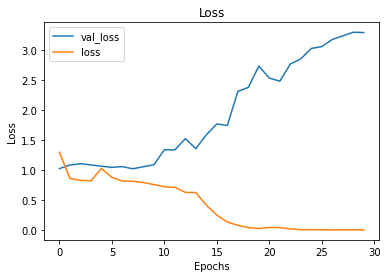

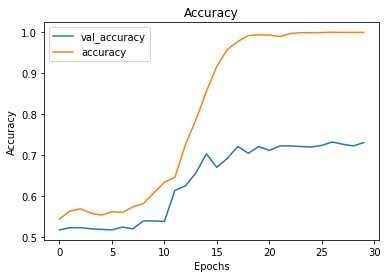

In [42]:
viz_train_res(history_cnn2)

After applying data augmentation, we see that overfitting is still an issue - although the trend of both validation loss and accuracy are a bit more predictable. Around epoch 15, overfitting becomes much more obvious. This could mean there's too much complication within our model itself. 

#### CNN With Data Augmentation & Dropout Layer

Dropout layers are another way of combatting overfitting issues. One dropout layer will be added after the last convolutional layer and before the dense layer and output. 

In [43]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (5,5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate = .5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=.003),
                loss="sparse_categorical_crossentropy",
                metrics='accuracy')

In [44]:
# Compiling with adam optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
# Training
history_cnn4 = model.fit(
        train_generator, 
        steps_per_epoch=int(training_sample/batch_size),
        validation_data = validation_generator,
        validation_steps = int(val_sample/batch_size),
        epochs=num_epochs,
        verbose=1)

Epoch 1/30
91/91 [==============================] - 134s 1s/step - loss: 1.1552 - accuracy: 0.5520 - val_loss: 1.0677 - val_accuracy: 0.5156
Epoch 2/30
91/91 [==============================] - 133s 1s/step - loss: 0.7202 - accuracy: 0.7788 - val_loss: 0.9068 - val_accuracy: 0.7585
Epoch 3/30
91/91 [==============================] - 132s 1s/step - loss: 0.5349 - accuracy: 0.8117 - val_loss: 0.5724 - val_accuracy: 0.7997
Epoch 4/30
91/91 [==============================] - 129s 1s/step - loss: 0.4577 - accuracy: 0.8332 - val_loss: 0.5637 - val_accuracy: 0.7898
Epoch 5/30
91/91 [==============================] - 129s 1s/step - loss: 0.3925 - accuracy: 0.8440 - val_loss: 0.4988 - val_accuracy: 0.8125
Epoch 6/30
91/91 [==============================] - 133s 1s/step - loss: 0.3732 - accuracy: 0.8422 - val_loss: 0.4679 - val_accuracy: 0.8239
Epoch 7/30
91/91 [==============================] - 132s 1s/step - loss: 0.3745 - accuracy: 0.8485 - val_loss: 0.4553 - val_accuracy: 0.8168
Epoch 8/30
91

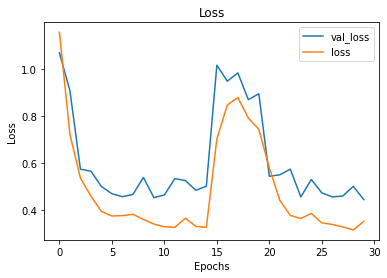

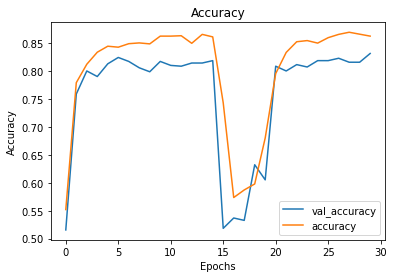

In [45]:
viz_train_res(history_cnn4)

In [59]:
#adjusting the axis of the above plots

def viz_train_res2(results):
    history = results.history
    plt.figure()
    plt.axis(ymax = 1)
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.axis(ymin = 0)
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

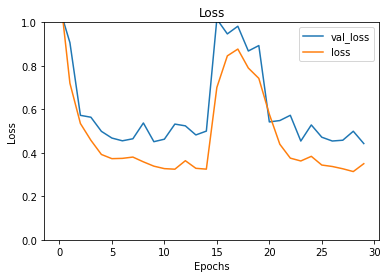

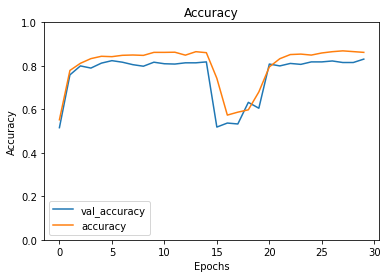

In [47]:
viz_train_res2(history_cnn4)

Adding this dropout layer seemed to solve for a lot of overfitting, however accuracy has gone down and there's concern about the dip in accuracy around epoch 15. 

This model has 2 convolutional layers, the next model will drop one of those layers in the hopes of solving for this dip and raising the overall accuracy while maintaining a lower level of overfitting. 

In [56]:
#removing a convolutional layer and keeping the dropout layer
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate = .5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=.003),
                loss="sparse_categorical_crossentropy",
                metrics='accuracy')

In [57]:
# Compiling with adam optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
# Training
history_cnn5 = model.fit(
        train_generator, 
        steps_per_epoch=int(training_sample/batch_size),
        validation_data = validation_generator,
        validation_steps = int(val_sample/batch_size),
        epochs=num_epochs,
        verbose=1)

Epoch 1/30
91/91 [==============================] - 143s 2s/step - loss: 1.5776 - accuracy: 0.7191 - val_loss: 0.6886 - val_accuracy: 0.6534
Epoch 2/30
91/91 [==============================] - 143s 2s/step - loss: 0.4636 - accuracy: 0.8051 - val_loss: 0.5248 - val_accuracy: 0.8068
Epoch 3/30
91/91 [==============================] - 141s 2s/step - loss: 0.3889 - accuracy: 0.8408 - val_loss: 0.4645 - val_accuracy: 0.8395
Epoch 4/30
91/91 [==============================] - 140s 2s/step - loss: 0.3704 - accuracy: 0.8488 - val_loss: 0.4313 - val_accuracy: 0.8352
Epoch 5/30
91/91 [==============================] - 140s 2s/step - loss: 0.3425 - accuracy: 0.8644 - val_loss: 0.4473 - val_accuracy: 0.8253
Epoch 6/30
91/91 [==============================] - 141s 2s/step - loss: 0.3435 - accuracy: 0.8558 - val_loss: 0.4286 - val_accuracy: 0.8338
Epoch 7/30
91/91 [==============================] - 143s 2s/step - loss: 0.3356 - accuracy: 0.8599 - val_loss: 0.4397 - val_accuracy: 0.8395
Epoch 8/30
91

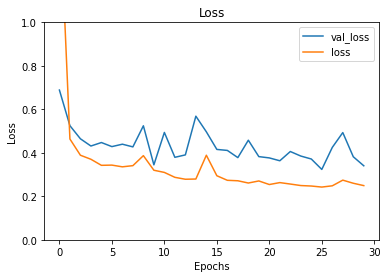

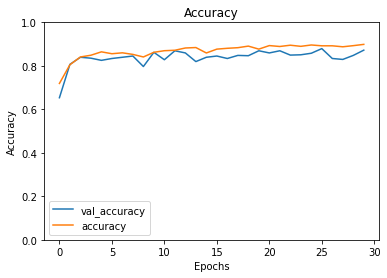

In [60]:
viz_train_res2(history_cnn5)

Although this model doesn't provide the highest accuracy, it does much better managing overfitting. Both accuracy and loss scores show less variance between training and validation sets. 

### Bringing in Test Data

In [61]:
# Rescaling images by 1./255
# Performing data augmentation on TESTING images
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range=90, fill_mode='nearest',
                                   brightness_range=[0.4,1.5],
                                   validation_split = 0.2)

# Flow training images in batches
test_generator = train_datagen.flow_from_directory(
        './split/test',
        target_size=(200, 200),
        batch_size=batch_size,
        classes = classes,
        class_mode='categorical')

Found 545 images belonging to 4 classes.


In [62]:
steps = test_generator.n

In [67]:
test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

18/18 [==============================] - 11s 636ms/step - loss: 0.4996 - accuracy: 0.7872
test acc: 0.7871559858322144
